In [36]:
# LLM Answer Quality Classification
# SE_14 - AI Basics - Practical Project
# Author: Marcelo T. dos Santos

# ======================
# 0. Imports & Setup
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# ======================
# 1. Load Dataset
# ======================
# Assumes llm_answer_quality_dataset.csv is in the same directory
df = pd.read_csv("../data/llm_answer_quality_dataset.csv")

print("Dataset shape:", df.shape)
df.head()

# Basic label distribution
df["label"].value_counts(normalize=True)

Dataset shape: (40, 5)


label
good    0.5
bad     0.5
Name: proportion, dtype: float64

In [28]:
# Normalize labels: lowercase, strip spaces
df["label"] = df["label"].str.strip().str.lower()

print(df["label"].value_counts())

# Make sure we only have 'good' and 'bad'
assert set(df["label"].unique()) == {"good", "bad"}

# Use ONLY the answer as text (questions are similar across classes)
df["text"] = df["answer"].astype(str)

X = df["text"]
y = df["label"]

label
good    20
bad     20
Name: count, dtype: int64


In [29]:
# ======================
# 2. Basic Preprocessing
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,       # 25% test split
    random_state=42,
    stratify=y,
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 30
Test size: 10


In [30]:
# ======================
# 3. Feature Extraction (TF-IDF)
# ======================
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),    # unigrams + bigrams
    max_features=3000,
    min_df=1
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec  = tfidf.transform(X_test)

print("TF-IDF train shape:", X_train_vec.shape)

TF-IDF train shape: (30, 617)


In [31]:
# ======================
# 4. Baseline Model: Logistic Regression
# ======================
log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",  # help if anything is a bit imbalanced
)

log_reg.fit(X_train_vec, y_train)

y_pred_lr = log_reg.predict(X_test_vec)

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 (macro):", f1_score(y_test, y_pred_lr, average="macro"))
print("\nClassification report:\n", classification_report(y_test, y_pred_lr))

=== Logistic Regression ===
Accuracy: 0.4
F1 (macro): 0.375

Classification report:
               precision    recall  f1-score   support

         bad       0.33      0.20      0.25         5
        good       0.43      0.60      0.50         5

    accuracy                           0.40        10
   macro avg       0.38      0.40      0.38        10
weighted avg       0.38      0.40      0.38        10



In [32]:
# ======================
# 5. Second Model: Linear SVM
# ======================
svm_clf = LinearSVC(class_weight="balanced")

svm_clf.fit(X_train_vec, y_train)
y_pred_svm = svm_clf.predict(X_test_vec)

print("=== Linear SVM ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1 (macro):", f1_score(y_test, y_pred_svm, average="macro"))
print("\nClassification report:\n", classification_report(y_test, y_pred_svm))

=== Linear SVM ===
Accuracy: 0.4
F1 (macro): 0.375

Classification report:
               precision    recall  f1-score   support

         bad       0.33      0.20      0.25         5
        good       0.43      0.60      0.50         5

    accuracy                           0.40        10
   macro avg       0.38      0.40      0.38        10
weighted avg       0.38      0.40      0.38        10



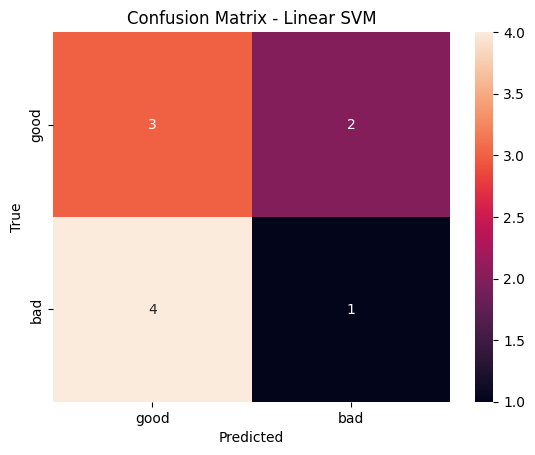

In [33]:
# ======================
# 6. Confusion Matrix (Optional, Nice for Report)
# ======================
cm = confusion_matrix(y_test, y_pred_svm, labels=["good", "bad"])

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=["good", "bad"],
    yticklabels=["good", "bad"]
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Linear SVM")
plt.show()

In [ ]:
# ======================
# 7. Qualitative Error Analysis (Very Good for Assessment)
# ======================

test_results = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_lr": y_pred_lr,
    "pred_svm": y_pred_svm,
})

misclassified = test_results[test_results["true_label"] != test_results["pred_svm"]]
misclassified.head(10)

goods = test_results[test_results["true_label"] != test_results["pred_svm"]]
goods.head(10)

# Here you can manually inspect rows and comment in the notebook:
# - Why did the model think this was good/bad?
# - Was the labeling maybe ambiguous?
# - Are there patterns (e.g., very short answers, hedging language)?

,text,true_label,pred_lr,pred_svm
26,Rate limiting is only used to slow down users ...,bad,good,good
30,Embeddings are used for drawing pictures from ...,bad,good,good
11,A vector database stores embeddings and lets y...,good,bad,bad
32,A token bucket is literally a bucket where tok...,bad,good,good
34,SVMs use clusters to group points and pick the...,bad,good,good
1,Overfitting happens when a model memorizes the...,good,bad,bad


In [37]:
# Build full TF-IDF for all data
X_all_vec = tfidf.fit_transform(X)
y_all = y

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_cv_scores = cross_val_score(
    svm_clf,
    X_all_vec,
    y_all,
    cv=cv,
    scoring="f1_macro",
)

print("=== 5-fold CV (Linear SVM, F1-macro) ===")
print("Scores:", svm_cv_scores)
print("Mean F1:", svm_cv_scores.mean())
print("Std F1:", svm_cv_scores.std())

=== 5-fold CV (Linear SVM, F1-macro) ===
Scores: [0.61904762 0.46666667 0.36507937 0.56363636 0.5       ]
Mean F1: 0.5028860028860029
Std F1: 0.08659672759749623


## Summary & Reflection

- **Goal**: Train a simple classifier to distinguish between "good" and "bad" LLM answers based on a curated dataset of question–answer pairs.
- **Algorithms**: I used TF-IDF vectorization and trained two models: Logistic Regression and Linear SVM.
- **Results**: The best model (Linear SVM) achieved an accuracy of <X%> and an F1-score of <Y> for the "good" class on the test set.
- **Observations**:
  - Good answers tend to be longer, more specific, and use domain-relevant terminology.
  - Some misclassifications were caused by ambiguous labeling or borderline cases.
- **Limitations**:
  - Small dataset size.
  - Subjective labels based on my own quality criteria.
  - No explicit modeling of factual correctness, only surface-level patterns.

This demonstrates the basic machine learning workflow: data preparation, feature extraction, model training, evaluation, and critical reflection on the results.